Activate conda environment anopheles.yml

In [89]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import sys
import seaborn
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

import os, io, random
import string

### Import data

In [90]:
td = pd.read_csv("../1_species-groups-thresholds/sample_info.csv", index_col=0)
td.head()

,targets_amplified,type,consensus_label,fine_sgp,intermediate_sgp,coarse_sgp,partner_label,BOLD_best_match,COI_best_match,COI_second_match,ITS2_best_match,ITS2_second_match,barcode_match_level,sgp_match_level,potential_conflict,single_representative
s_Sample,,,,,,,,,,,,,,,,
Adem-32,28,amplicon_panel,Anopheles_demeilloni_c,Anopheles_marshallii_complex,Anopheles_marshallii_group,Myzomyia_Neocellia_series,Anopheles_demeilloni,No_match,Anopheles_sp.,Anopheles_sp.,Anopheles_sp.,Anopheles_theileri,close_sp,fine,NaN,False
Abro-33,38,amplicon_panel,Anopheles_brohieri_c,Anopheles_marshallii_complex,Anopheles_marshallii_group,Myzomyia_Neocellia_series,Anopheles_brohieri,No_match,Anopheles_sp.,Anopheles_sp.,Anopheles_sp.,Anopheles_theileri,close_sp,fine,NaN,False
Ahan-615,53,amplicon_panel,Anopheles_hancocki_c,Anopheles_marshallii_complex,Anopheles_marshallii_group,Myzomyia_Neocellia_series,Anopheles_hancocki,No_match,Anopheles_sp.,Anopheles_sp.,Anopheles_sp.,Anopheles_theileri,close_sp,fine,NaN,False
Ahan-6-1,59,amplicon_panel,Anopheles_hancocki_c,Anopheles_marshallii_complex,Anopheles_marshallii_group,Myzomyia_Neocellia_series,Anopheles_hancocki,No_match,Anopheles_sp.,Anopheles_sp.,Anopheles_sp.,Anopheles_theileri,close_sp,fine,NaN,False
Abro-22,62,amplicon_panel,Anopheles_brohieri_c,Anopheles_marshallii_complex,Anopheles_marshallii_group,Myzomyia_Neocellia_series,Anopheles_brohieri,No_match,Anopheles_sp.,Anopheles_sp.,Anopheles_sp.,Anopheles_theileri,close_sp,fine,NaN,False


In [91]:
#import files
refbase = pd.read_csv("../../data/haplotypes-NNv1.csv")
refbase.head()

,s_Sample,target,consensus
0,Abro-21,13,CATTTCTATCTGATGAAACTTGTGCCCGTGGTTTAATTAATGCGTA...
1,Abro-21,17,GGTCTAGACCCGGAAGCCCTCACCGGCAAATACCCGGTAAGTGTTT...
2,Abro-21,18,AAAAAGGATGAGGTGAGTACCAGACTCCTCCCAGAATGATTATAAT...
3,Abro-21,19,TATTTGTCCACCTTTTGCCGACCGAGTTTTCTTGCCCGAGACGCGT...
4,Abro-21,24,AATGTAGCCCCGAGCGCGAAGCCGTGAAGCTTCTGCGCGCCACCTC...


In [92]:
def assign_combUID(haplotypes): 
    # assign IDs to unique sequences
    combuids = dict()
    for tgt, group in haplotypes.groupby(['target']):
        for (i, cons) in enumerate(group['consensus'].unique()):
            combuids[str(tgt)+cons] = '{}-{}'.format(tgt, i)
    haplotypes['combUID'] = (haplotypes.target.astype('str') + haplotypes.consensus).replace(combuids)
    return(haplotypes)

In [93]:
refbase = assign_combUID(refbase)
refbase.head()

,s_Sample,target,consensus,combUID
0,Abro-21,13,CATTTCTATCTGATGAAACTTGTGCCCGTGGTTTAATTAATGCGTA...,13-0
1,Abro-21,17,GGTCTAGACCCGGAAGCCCTCACCGGCAAATACCCGGTAAGTGTTT...,17-0
2,Abro-21,18,AAAAAGGATGAGGTGAGTACCAGACTCCTCCCAGAATGATTATAAT...,18-0
3,Abro-21,19,TATTTGTCCACCTTTTGCCGACCGAGTTTTCTTGCCCGAGACGCGT...,19-0
4,Abro-21,24,AATGTAGCCCCGAGCGCGAAGCCGTGAAGCTTCTGCGCGCCACCTC...,24-0


In [94]:
#Add allelic zygosity
zygosity = 2/refbase.groupby(['s_Sample', 'target'])['combUID'].nunique()
zygosity = pd.DataFrame(zygosity).reset_index()
zygosity_dict = dict(zip(zygosity.s_Sample + zygosity.target.astype('str'), zygosity.combUID))
refbase['zygosity'] = (refbase.s_Sample + refbase.target.astype('str')).replace(zygosity_dict)
refbase.head()

,s_Sample,target,consensus,combUID,zygosity
0,Abro-21,13,CATTTCTATCTGATGAAACTTGTGCCCGTGGTTTAATTAATGCGTA...,13-0,2.0
1,Abro-21,17,GGTCTAGACCCGGAAGCCCTCACCGGCAAATACCCGGTAAGTGTTT...,17-0,2.0
2,Abro-21,18,AAAAAGGATGAGGTGAGTACCAGACTCCTCCCAGAATGATTATAAT...,18-0,2.0
3,Abro-21,19,TATTTGTCCACCTTTTGCCGACCGAGTTTTCTTGCCCGAGACGCGT...,19-0,2.0
4,Abro-21,24,AATGTAGCCCCGAGCGCGAAGCCGTGAAGCTTCTGCGCGCCACCTC...,24-0,2.0


In [95]:
#Check that it sums to 2 for all samples
(refbase.groupby(['s_Sample', 'target'])['zygosity'].sum()==2).all()

True

In [96]:
tdfdict = dict(zip(td.index, td.fine_sgp))
tdidict = dict(zip(td.index, td.intermediate_sgp))
tdcdict = dict(zip(td.index, td.coarse_sgp))
refbase['fine_sgp'] = refbase.s_Sample.map(tdfdict)
refbase['intermediate_sgp'] = refbase.s_Sample.map(tdidict)
refbase['coarse_sgp'] = refbase.s_Sample.map(tdcdict)

In [97]:
#make refbase entries categorical
refbase['fine_sgp'] = pd.Categorical(refbase['fine_sgp'], ['Anopheles_marshallii_complex', 'Anopheles_marshallii_cp_sp1',
       'Anopheles_theileri', 'Anopheles_moucheti', 'Anopheles_jebudensis',
       'Myzomyia_sp1', 'Anopheles_gabonensis', 'Anopheles_funestus',
       'Anopheles_rhodesiensis', 'Anopheles_minimus_A',
       'Anopheles_culicifacies', 'Anopheles_aconitus', 'Anopheles_rampae',
       'Anopheles_maculatus_A', 'Anopheles_maculatus_B',
       'Anopheles_maculipalpis', 'Anopheles_annularis',
       'Anopheles_jamesii', 'Anopheles_stephensi',
       'Anopheles_gambiae_coluzzii', 'Anopheles_arabiensis',
       'Anopheles_gambiae_cp_sp1', 'Anopheles_quadriannulatus',
       'Anopheles_melas', 'Anopheles_merus', 'Anopheles_christyi',
       'Anopheles_sundaicus_complex', 'Anopheles_vagus',
       'Anopheles_dirus_A', 'Anopheles_balabacensis', 'Anopheles_cracens',
       'Anopheles_koliensis', 'Anopheles_farauti',
       'Anopheles_punctulatus', 'Anopheles_tessellatus',
       'Anopheles_coustani_cp_cl3', 'Anopheles_coustani_cp_cl2', 
       'Anopheles_coustani_cp_cl1', 'Anopheles_hyrcanus_gp_sp1', 
       'Anopheles_hyrcanus_gp_sp2', 'Anopheles_sinensis',
       'Anopheles_barbirostris', 'Anopheles_atroparvus',
       'Anopheles_implexus', 'Anopheles_nili_gp_sp3',
       'Anopheles_nili_gp_sp2', 'Anopheles_nili_gp_sp1',
       'Anopheles_carnevalei', 'Anopheles_vinckei', 'Anopheles_dureni',
       'Anopheles_aquasalis', 'Anopheles_oryzalimnetes',
       'Anopheles_darlingi', 'Anopheles_albimanus', 'Anopheles_cruzii',
       'Anopheles_bellator'], ordered=True)

In [98]:
#make refbase entries categorical
refbase['intermediate_sgp'] = pd.Categorical(refbase['intermediate_sgp'],['Anopheles_marshallii_group', 'Anopheles_moucheti_group',
       'Myzomyia_sp1', 'Anopheles_gabonensis', 'Anopheles_funestus',
       'Anopheles_rhodesiensis', 'Anopheles_minimus_A',
       'Anopheles_culicifacies', 'Anopheles_aconitus',
       'Anopheles_maculatus_group', 'Anopheles_maculipalpis',
       'Anopheles_annularis', 'Anopheles_jamesii', 'Anopheles_stephensi',
       'Anopheles_gambiae_complex', 'Anopheles_christyi',
       'Anopheles_sundaicus_complex', 'Anopheles_vagus',
       'Anopheles_dirus_complex', 'Anopheles_punctulatus_group',
       'Anopheles_tessellatus', 'Anopheles_coustani_complex',
       'Anopheles_hyrcanus_gp_sp1', 'Anopheles_sinensis_group',
       'Anopheles_barbirostris', 'Anopheles_atroparvus',
       'Anopheles_implexus', 'Anopheles_nili_group', 'Anopheles_vinckei',
       'Anopheles_dureni', 'Anopheles_aquasalis',
       'Anopheles_oryzalimnetes', 'Anopheles_darlingi',
       'Anopheles_albimanus', 'Kerteszia_subgenus'], ordered=True)

In [99]:
#make refbase entries categorical
refbase['coarse_sgp'] = pd.Categorical(refbase['coarse_sgp'], ['Myzomyia_Neocellia_series', 'Pyretophorus_series',
       'Neomyzomyia_series_I', 'Myzorhynchus_series', 'Christya_series',
       'Neomyzomyia_series_II', 'Neomyzomyia_series_III',
       'Nyssorhynchus_subgenus', 'Kerteszia_subgenus'], ordered=True)

In [100]:
samples = td.index.values

### Functions

In [101]:
#compute assignment per target - per individual
#this version is adjusted to drop the individual out of the refdatabase
#@amp: haplotype dataframe restricuted to target a
#@a: target number (integer)
#@samp1: name of individual
#@n: integer corresponding to number of individual in ordered samples list
#@refkmers: table of unique kmer sequences in database
#@tb10, tb30, tb38: output table for fine, intermediate and coarse assignments respectively
def individual_combUID_dist(amp, a, samp1, n, refkmers, tb10, tb30, tb48):
    #sequences from individual
    sqic = amp.loc[amp.s_Sample == samp1, 'combUID'].unique()
    #dropout sample from haplotypes
    ampf = amp.copy()
    ampf.drop(ampf.loc[ampf.s_Sample == samp1].index, inplace=True)
    #allowed matching sequences
    sqmc = ampf['combUID'].str.split('-', expand=True)[1]
    #array of allowed matches
    sqar = np.isin(np.arange(refkmers.shape[1]).astype('str'), sqmc)
    #zygosity of individual
    z = 2/len(sqic)
    #compute allelic distances per haplotype
    for sq in sqic:
        s = int(sq.split('-')[1])
        #compute distances normalised for sequence length
        dists = np.sum(np.abs(refkmers[a,:,:] - refkmers[a,s,:]),axis=1)/np.sum(refkmers[a,:,:] + refkmers[a,s,:], axis=1)
        #mask invalid comparisons
        dists = np.where(sqar, dists, np.nan)
        #find minimisers
        minisq = np.arange(refkmers.shape[1])[dists==np.nanmin(dists)]
        minisqcb = np.core.defchararray.add(np.array(['{}-'.format(a)]), minisq.astype(str))
        #include neighbour column weighed by zygosity
        ampf.loc[:,'neighbours'] = ampf.loc[:,'combUID'].isin(minisqcb)*ampf.loc[:,'zygosity']
        for level, table in zip(['fine_sgp', 'intermediate_sgp', 'coarse_sgp'], [tb10, tb30, tb48]):
            #per level, compute the neighbour allele frequency
            nsum = ampf.groupby(level)['neighbours'].sum()
            zsum = ampf.groupby(level)['zygosity'].sum()
            nb = nsum/zsum
            #normalise such that per sample neighbour frequency is 2 (diploid)
            table[a,n,:] += z*nb/np.sum(nb)
    return(tb10, tb30, tb48)

In [102]:
def construct_assignment_array(refbase, refkmers, samples):
    
    #initialise assignment arrays
    nntd10 = np.zeros((62, len(samples), refbase.fine_sgp.nunique()))
    nntd30 = np.zeros((62, len(samples), refbase.intermediate_sgp.nunique()))
    nntd48 = np.zeros((62, len(samples), refbase.coarse_sgp.nunique()))
    
    
    #restrict to per amplicon
    for a in np.arange(62):
        amp = refbase.loc[refbase.target == a]
        
        #iterate through samples
        for e, samp1 in enumerate(samples):
            #check that sample has amplified at this target
            if np.isin(samp1, amp.s_Sample):
                nntd10, nntd30, nntd48 = individual_combUID_dist(amp, a, samp1, e, refkmers, nntd10, nntd30, nntd48)

        print("amplicon ", a, " done")
    return(nntd10, nntd30, nntd48)
            
    

In [103]:
def construct_kmer_dict(k):
    labels = []
    for i in itertools.product('ACGT', repeat=k):
        labels.append(''.join(i))
    kmerdict = dict(zip(labels, np.arange(4**k)))
    return(kmerdict)

In [104]:
def sample_kmer_table(k, seq, no_amp, x):
    kmerdict = construct_kmer_dict(k)
    table = np.zeros((no_amp, x, 4**k), dtype='int')
    for r in seq.index:
        combid = str.split(seq.loc[r,'combUID'], '-')
        t, u = int(combid[0]), int(combid[1])
        sq = seq.loc[r,'consensus']
        for i in np.arange(len(sq)-(k-1)):
            table[t,u,kmerdict[sq[i:i+k]]] += 1
    return(table)

### Process data

In [105]:
#Make array unique 8mers
maxallele = refbase.groupby('target')['combUID'].nunique().max()
combUIDunique = refbase[['combUID', 'consensus']].drop_duplicates()
ref8mers = sample_kmer_table(8, combUIDunique, 62, maxallele)

In [106]:
nntd10, nntd30, nntd48 = construct_assignment_array(refbase, ref8mers, samples)

amplicon  0  done
amplicon  1  done
amplicon  2  done
amplicon  3  done
amplicon  4  done
amplicon  5  done
amplicon  6  done
amplicon  7  done
amplicon  8  done
amplicon  9  done
amplicon  10  done
amplicon  11  done
amplicon  12  done
amplicon  13  done
amplicon  14  done
amplicon  15  done
amplicon  16  done
amplicon  17  done
amplicon  18  done
amplicon  19  done
amplicon  20  done
amplicon  21  done
amplicon  22  done
amplicon  23  done
amplicon  24  done
amplicon  25  done
amplicon  26  done
amplicon  27  done
amplicon  28  done
amplicon  29  done
amplicon  30  done
amplicon  31  done
amplicon  32  done
amplicon  33  done
amplicon  34  done
amplicon  35  done
amplicon  36  done
amplicon  37  done
amplicon  38  done
amplicon  39  done
amplicon  40  done
amplicon  41  done
amplicon  42  done
amplicon  43  done
amplicon  44  done
amplicon  45  done
amplicon  46  done
amplicon  47  done
amplicon  48  done
amplicon  49  done
amplicon  50  done
amplicon  51  done
amplicon  52  done
amp

In [107]:
#make the results into a dataframe
a48 = np.nansum(nntd48, axis=0)/np.sum(np.nansum(nntd48, axis=0), axis=1)[:,None]
res_coarse = pd.DataFrame(a48, index=samples, columns=refbase.coarse_sgp.cat.categories)
res_coarse.to_csv("results/1_coarse_assignment.csv")

In [108]:
#make the results into a dataframe
a30 = np.nansum(nntd30, axis=0)/np.sum(np.nansum(nntd30, axis=0), axis=1)[:,None]
res_int = pd.DataFrame(a30, index=samples, columns=refbase.intermediate_sgp.cat.categories)
res_int.to_csv("results/1_intermediate_assignment.csv")

In [109]:
#make the results into a dataframe
a10 = np.nansum(nntd10, axis=0)/np.sum(np.nansum(nntd10, axis=0), axis=1)[:,None]
res_fine = pd.DataFrame(a10, index=samples, columns=refbase.fine_sgp.cat.categories)
res_fine.to_csv("results/1_fine_assignment.csv")

In [110]:
#Pick unique colors for each of the fine assignment categories
turquoise = np.concatenate([plt.cm.Dark2(np.arange(8))[:1], plt.cm.Set2(np.arange(8))[:1], plt.cm.Set3(np.arange(12))[:1], plt.cm.Pastel2(np.arange(8))[:1]])
yellows = np.concatenate([plt.cm.Set2(np.arange(8))[5:6], plt.cm.Set3(np.arange(12))[11:], plt.cm.Set1(np.arange(9))[5:6], plt.cm.Set3(np.arange(12))[1:2]])
blues = np.array([[5,8,84,200], [12,16,148,200], [0,8,255,200], [52,82,235,200]])/256
browns =  np.array([[56,22,6,200], [125,45,5,200], [148,67,27,200], [194, 72, 12, 200]])/256 
colorsb = plt.cm.tab20b(np.arange(20))
colorsc = plt.cm.tab20c(np.arange(20))
colors = np.concatenate([colorsb, colorsc, turquoise, yellows, blues, browns])

In [111]:
colors30 = np.delete(colors, [1,2,4,13,14,19,21,22,23,24,29,30,31,33,35,38,39,45,46,47,54], axis=0)

In [113]:
colors48 = colors[[17, 20, 28, 36, 43, 44, 48, 51, 55 ],:]

In [114]:
fine_lines = refbase.groupby('fine_sgp')['s_Sample'].nunique().values
fine_lines = fine_lines.cumsum()-.5
int_lines = refbase.groupby('intermediate_sgp')['s_Sample'].nunique().values
int_lines = int_lines.cumsum()-.5
coarse_lines = refbase.groupby('coarse_sgp')['s_Sample'].nunique().values
coarse_lines = coarse_lines.cumsum()-.5

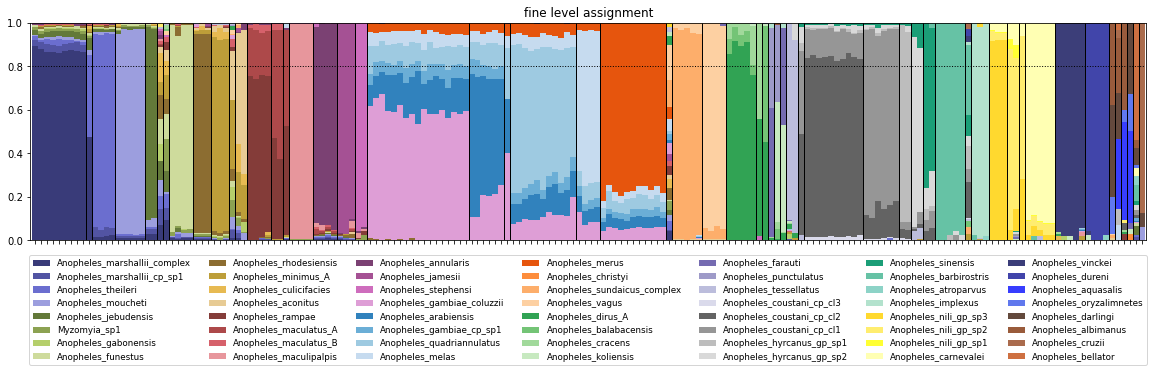

In [115]:
level='fine'
lines = fine_lines
assignment = res_fine
levelcolor=colors
fig, ax = plt.subplots(figsize=(20,7))
assignment.plot(kind='bar', stacked=True, width=1, ax=ax, color=levelcolor)
ax.set_xticklabels('')
ax.set_title("{} level assignment".format(level))
ax.vlines(lines[:-1], 0, 1, color='k', linewidth=1)
ax.hlines(.8, -.5, 185.5, color='k', ls = ':', linewidth=1)
box = ax.get_position()
ax.set_position([box.x0, box.y0+3/7*box.height, box.width, box.height*4/7])
leg1 = ax.legend(loc='upper center', ncol=7, bbox_to_anchor=(0.5, -.05), fontsize=8.7)
ax.margins(y=0)
plt.savefig("results/{}_assignment.png".format(level))
plt.savefig("results/{}_assignment.pdf".format(level))

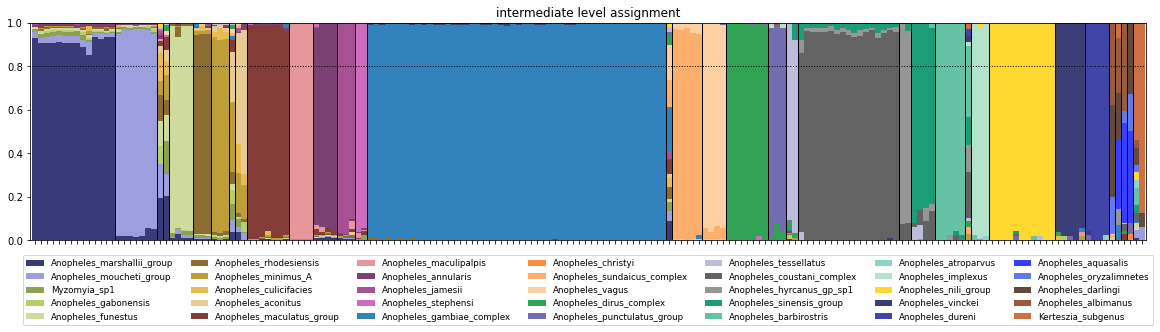

In [118]:
level='intermediate'
lines = int_lines
assignment = res_int
levelcolor=colors30
fig, ax = plt.subplots(figsize=(20,7))
assignment.plot(kind='bar', stacked=True, width=1, ax=ax, color=levelcolor)
ax.set_xticklabels('')
ax.set_title("{} level assignment".format(level))
ax.vlines(lines[:-1], 0, 1, color='k', linewidth=1)
ax.hlines(.8, -.5, 185.5, color='k', ls = ':', linewidth=1)
box = ax.get_position()
ax.set_position([box.x0, box.y0+3/7*box.height, box.width, box.height*4/7])
leg1 = ax.legend(loc='upper center', ncol=7, bbox_to_anchor=(0.5, -.05), fontsize=8.7)
ax.margins(y=0)
plt.savefig("results/{}_assignment.png".format(level))
plt.savefig("results/{}_assignment.pdf".format(level))

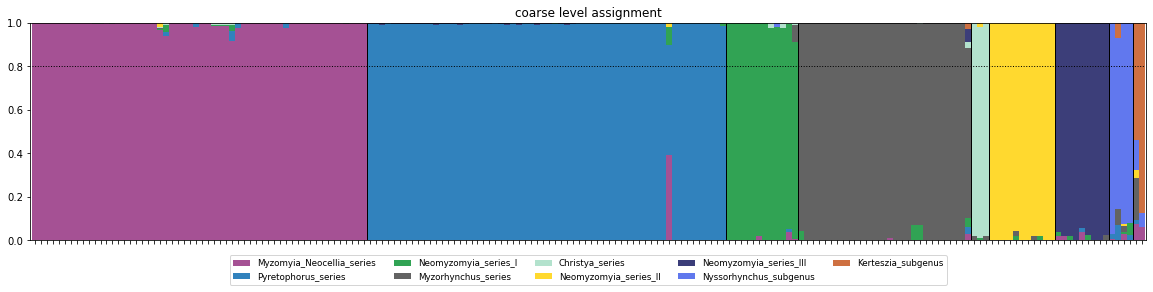

In [120]:
level='coarse'
lines = coarse_lines
assignment = res_coarse
levelcolor=colors48
fig, ax = plt.subplots(figsize=(20,7))
assignment.plot(kind='bar', stacked=True, width=1, ax=ax, color=levelcolor)
ax.set_xticklabels('')
ax.set_title("{} level assignment".format(level))
ax.vlines(lines[:-1], 0, 1, color='k', linewidth=1)
ax.hlines(.8, -.5, 185.5, color='k', ls = ':', linewidth=1)
box = ax.get_position()
ax.set_position([box.x0, box.y0+3/7*box.height, box.width, box.height*4/7])
leg1 = ax.legend(loc='upper center', ncol=5, bbox_to_anchor=(0.5, -.05), fontsize=8.7)
ax.margins(y=0)
plt.savefig("results/{}_assignment.png".format(level))
plt.savefig("results/{}_assignment.pdf".format(level))

### Correct assignment per level

In [122]:
iterative_assignment = pd.DataFrame(index=samples, columns=['fine_sgp', 'intermediate_sgp', 'coarse_sgp'])
for l, level, table in zip(['fine_sgp', 'intermediate_sgp', 'coarse_sgp'], 
                           ['fine_sgp', 'intermediate_sgp', 'coarse_sgp'],
                           [nntd10, nntd30, nntd48]):
    assignment = np.nansum(table, axis=0)/np.sum(np.nansum(table, axis=0), axis=1)[:,None]
    assignment = pd.DataFrame(assignment, index=samples, columns=refbase['{}'.format(l)].cat.categories)
    iterative_assignment['{}'.format(l)] = assignment.apply(lambda x: x[td.loc[x.name,'{}'.format(level)]], axis=1)

In [124]:
iterative_assignment.head()

,fine_sgp,intermediate_sgp,coarse_sgp
Adem-32,0.891176,0.929822,1.0
Abro-33,0.881150,0.906739,1.0
Ahan-615,0.863543,0.907066,1.0
Ahan-6-1,0.864050,0.906949,1.0
Abro-22,0.859778,0.911451,1.0


In [129]:
#Check monotony
(iterative_assignment.intermediate_sgp - iterative_assignment.fine_sgp > -0.00001).all()

True

In [130]:
#Check monotony
(iterative_assignment.coarse_sgp - iterative_assignment.intermediate_sgp > -0.00001).all()

True

In [131]:
iterative_for_plot = iterative_assignment.copy()
iterative_for_plot['intermediate_sgp'] = iterative_assignment['intermediate_sgp'] - iterative_assignment['fine_sgp']
iterative_for_plot['coarse_sgp'] = iterative_assignment['coarse_sgp'] - iterative_assignment['intermediate_sgp']

In [132]:
iterative_assignment.to_csv("results/1_correct_level_assignments.csv")
iterative_for_plot.to_csv("results/1_cum_correct_level_assignments.csv")

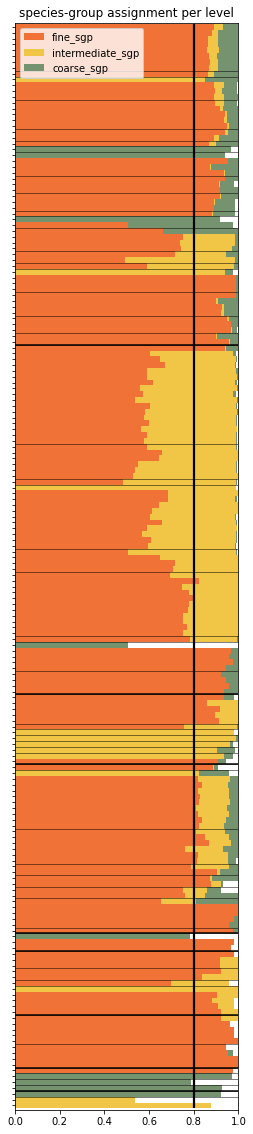

In [145]:
fig, ax = plt.subplots(figsize=(4,20))
iterative_for_plot.iloc[::-1].plot(kind='barh', stacked=True, width=1, ax=ax, color=["#F17236", "#F1C646", "#769370"])
ax.set_yticklabels('')
ax.set_title("species-group assignment per level".format(level))
ax.hlines(186-fine_lines[:-1], 0, 1, color='k', linewidth=.5)
ax.hlines(186-coarse_lines[:-1], 0, 1, color='k', linewidth=1.5)
ax.vlines(.8, -.5, 185.5, color='k', ls = '-', linewidth=2.2)
ax.legend(loc=2)
ax.margins(x=0)
plt.savefig("results/1_level_assignment.png")
plt.savefig("results/1_level_assignment.pdf")

In [148]:
tree = plt.imread("NNv1_tree.png")

In [202]:
labels = []
for a in ['Anopheles_marshallii_c', 'Anopheles_marshallii_sp1',
       'Anopheles_theileri', 'Anopheles_moucheti', 'Anopheles_jebudensis',
       'Anopheles_myzomyia_sp1', 'Anopheles_gabonensis', 'Anopheles_funestus',
       'Anopheles_rhodesiensis', 'Anopheles_minimus_A',
       'Anopheles_culicifacies', 'Anopheles_aconitus', 'Anopheles_rampae',
       'Anopheles_maculatus_A', 'Anopheles_maculatus_B',
       'Anopheles_maculipalpis', 'Anopheles_annularis',
       'Anopheles_jamesii', 'Anopheles_stephensi',
       'Anopheles_gambiae_coluzzii', 'Anopheles_arabiensis',
       'Anopheles_gambiae_sp1', 'Anopheles_quadriannulatus',
       'Anopheles_melas', 'Anopheles_merus', 'Anopheles_christyi',
       'Anopheles_sundaicus_c', 'Anopheles_vagus',
       'Anopheles_dirus_A', 'Anopheles_balabacensis', 'Anopheles_cracens',
       'Anopheles_koliensis', 'Anopheles_farauti',
       'Anopheles_punctulatus', 'Anopheles_tessellatus',
       'Anopheles_coustani_cl3', 'Anopheles_coustani_cl2', 
       'Anopheles_coustani_cl1', 'Anopheles_hyrcanus_sp1', 
       'Anopheles_hyrcanus_sp2', 'Anopheles_sinensis',
       'Anopheles_barbirostris', 'Anopheles_atroparvus',
       'Anopheles_implexus', 'Anopheles_nili_sp3',
       'Anopheles_nili_sp2', 'Anopheles_nili_sp1',
       'Anopheles_carnevalei', 'Anopheles_vinckei', 'Anopheles_dureni',
       'Anopheles_aquasalis', 'Anopheles_oryzalimnetes',
       'Anopheles_darlingi', 'Anopheles_albimanus', 'Anopheles_cruzii',
       'Anopheles_bellator']:
    labels.append('An.'+a[10:])

In [204]:
pos = np.append(np.array([-.5]), fine_lines)
pos = (pos[1:] + pos[:-1])/2
pos

array([  4. ,   9. ,  11.5,  16. ,  19.5,  21. ,  22. ,  24.5,  28. ,
        31. ,  33. ,  34.5,  37.5,  40.5,  42. ,  44.5,  48.5,  52. ,
        54.5,  64. ,  75.5,  79. ,  85. ,  92.5, 100. , 106. , 109. ,
       113.5, 118. , 121. , 122. , 123. , 124. , 125. , 126.5, 128. ,
       133.5, 141.5, 145.5, 147.5, 149.5, 153. , 156. , 158. , 161. ,
       163.5, 165. , 168. , 173. , 177.5, 180. , 181. , 182. , 183. ,
       184. , 185. ])

In [216]:
pos = np.array([  4. ,   9. ,  11.5,  16. ,  19.5,  21. ,  22.5 ,  24.5,  28. ,
        31. ,  33. ,  34.5,  37.5,  40,  42. ,  44.5,  48.5,  52. ,
        54.5,  64. ,  75.5,  79. ,  85. ,  92.5, 100. , 106. , 109. ,
       113.5, 118. , 120. , 121.5, 123. , 124.5 , 126. , 127.5, 129. ,
       133.5, 141.5, 145.5, 147.5, 149.5, 153. , 156. , 158. , 161. ,
       163.5, 166. , 168. , 173. , 177.5, 179.5 , 181. , 182.5 , 184. ,
       185.5 , 187. ])
xpos = np.array([-0.45, -0.45, -0.45, -0.45, -0.45, -0.45, -0.45, -0.45, -0.45,
       -0.45, -0.45, -0.45, -0.45, -0.45, -0.45, -0.45, -0.45, -0.45,
       -0.45, -0.55, -0.45, -0.45, -0.55, -0.45, -0.45, -0.45, -0.45,
       -0.45, -0.45, -0.45, -0.45, -0.45, -0.45, -0.45, -0.45, -0.45,
       -0.45, -0.45, -0.45, -0.45, -0.45, -0.45, -0.45, -0.45, -0.45,
       -0.45, -0.45, -0.45, -0.45, -0.45, -0.45, -0.45, -0.45, -0.45,
       -0.45, -0.45])

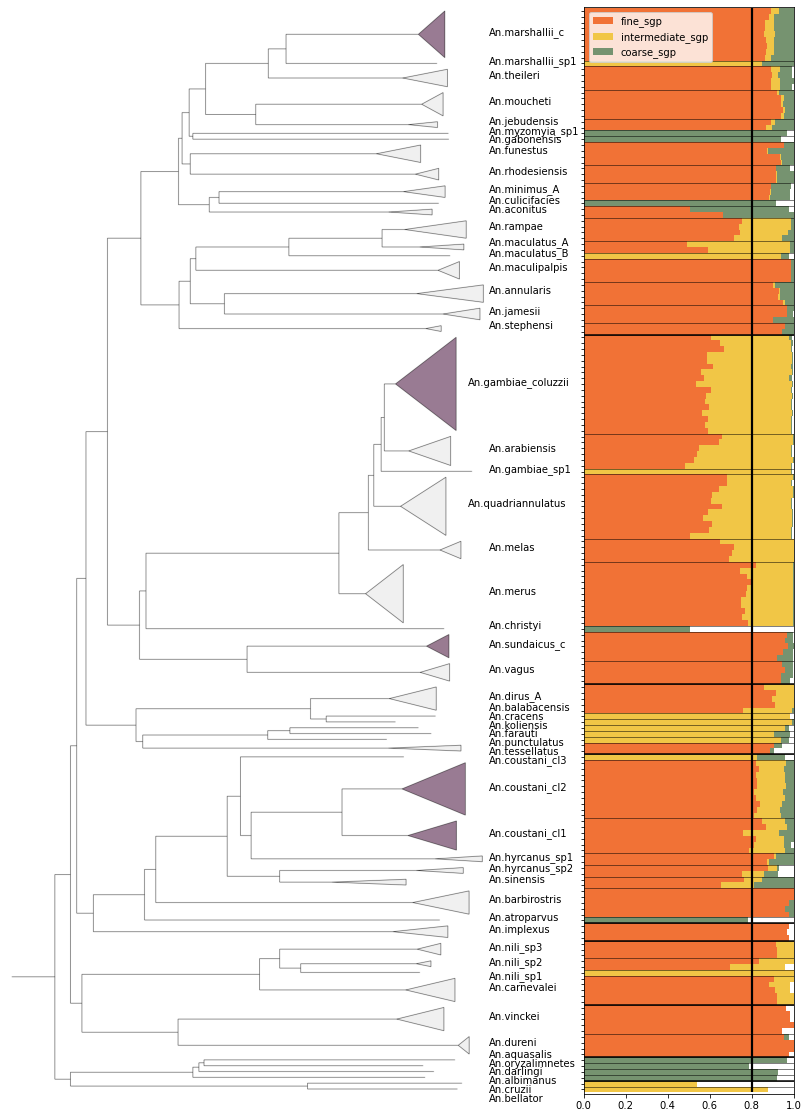

In [217]:
e = 10
fig, ax = plt.subplots(1,2, figsize=(4.5+e,20), gridspec_kw={'width_ratios': [e, 4]})
iterative_for_plot.iloc[::-1].plot(kind='barh', stacked=True, width=1, ax=ax[1], color=["#F17236", "#F1C646", "#769370"])
ax[1].set_yticklabels('')
ax[1].set_ylabel('')
ax[1].hlines(185-fine_lines[:-1], 0, 1, color='k', linewidth=.5)
ax[1].hlines(185-coarse_lines[:-1], 0, 1, color='k', linewidth=1.5)
ax[1].vlines(.8, -.5, 185.5, color='k', ls = '-', linewidth=2.2)
ax[1].legend(loc=2)
ax[1].margins(x=0)
ax[1].margins(y=0)
ax[0].imshow(tree)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['left'].set_visible(False)
for s, p, x in zip(labels, 185-pos, xpos):
    ax[1].text(x,p,s)
plt.subplots_adjust(wspace=0.2)
plt.savefig("1_NNresults.png")